# Geometric Brownian Motion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
returns_train = pd.read_csv('data/returns_train.csv', index_col=0)
returns_train.index = pd.to_datetime(returns_train.index)
returns_train.head()

,brent,crude,gasoline,heating,gas,natural
date,,,,,,
2008-01-02,-0.002453,-0.004417,-0.001007,-0.007773,0.006433,-0.022420
2008-01-03,-0.008299,-0.012805,-0.004679,-0.013093,-0.016270,0.021762
2008-01-04,-0.024796,-0.028802,-0.028853,-0.033538,-0.035440,0.004846
2008-01-07,0.012183,0.013040,0.012435,0.016503,0.027863,0.011169
2008-01-08,-0.012246,-0.006851,-0.015620,-0.008686,0.005958,0.016568


## $\mu$ fitting

In [3]:
mu = returns_train.mean(axis=0)
mu

brent       0.000016
crude       0.000042
gasoline    0.000131
heating     0.000003
gas        -0.000053
natural     0.000081
dtype: float64

## $\sigma$ fitting

In [4]:
sigma = returns_train.std(axis=0)
sigma

brent       0.022331
crude       0.024827
gasoline    0.025380
heating     0.020604
gas         0.018850
natural     0.030239
dtype: float64

## Correlation fitting

In [5]:
corr = np.corrcoef(returns_train.T)
pd.DataFrame(corr.round(2))

,0,1,2,3,4,5
0,1.00,0.87,0.75,0.88,0.64,0.18
1,0.87,1.00,0.68,0.79,0.58,0.18
2,0.75,0.68,1.00,0.70,0.48,0.15
3,0.88,0.79,0.70,1.00,0.66,0.20
4,0.64,0.58,0.48,0.66,1.00,0.12
5,0.18,0.18,0.15,0.20,0.12,1.00


## Initial prices

In [6]:
prices = pd.read_csv('data/prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)
prices.iloc[2433]

brent        55.2300
crude        52.7500
gasoline      1.5667
heating       1.6265
gas         485.5000
natural       3.2430
Name: 2017-01-23 00:00:00, dtype: float64

## Generation

In [7]:
dt = 1
T = 1042
N = int(T / dt)
x0 = prices.iloc[2433].tolist()
ts = np.arange(1, N + 1)
n_sim = 10
sims = []

In [8]:
for i in range(n_sim):
    sims.append({})
    W_values = np.random.normal(size=(returns_train.shape[1], N))
    W_values = (np.linalg.cholesky(corr) @ W_values).T
    W_process = W_values.cumsum(axis=0)
    sims[i]['W_process'] = W_process

In [9]:
for i in range(n_sim):
    drift = (mu - 0.5 * sigma**2).tolist() * np.tile(ts, (returns_train.shape[1], 1)).T
    diffusion = sigma.tolist() * sims[i]['W_process']
    sims[i]['drift'] = drift
    sims[i]['diffusion'] = diffusion

In [10]:
for i in range(n_sim):
    X = x0 * np.exp(sims[i]['drift'] + sims[i]['diffusion'])
    sims[i]['X'] = X

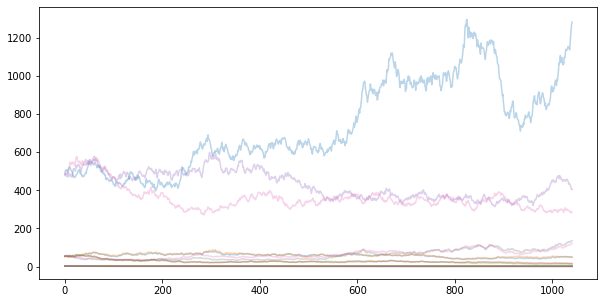

In [11]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(sims[i]['X'], alpha = 0.3)
plt.show()

In [12]:
returns_list = []
for i in range(n_sim):
    returns_list.append(
        (sims[i]['X'][1:] - sims[i]['X'][:-1]) / sims[i]['X'][:-1]
    )
gen_returns = np.concatenate(returns_list)
pd.DataFrame(gen_returns, columns=returns_train.columns).to_csv('data/gen_gbm.csv')